In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import rotate

Setting environment for Gordon


In [2]:
cell_masks_normalized = bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_cells/fractal_dim/cell_masks_normalized.bp')

In [3]:
n_cells = len(cell_masks_normalized)
print n_cells, 'cells'

cell_masks_normalized_flattened = np.reshape(cell_masks_normalized, (len(cell_masks_normalized), -1))
cell_masks_normalized_flattened.shape

cell_masks_normalized_size = cell_masks_normalized_flattened.sum(axis=1)

197953 cells


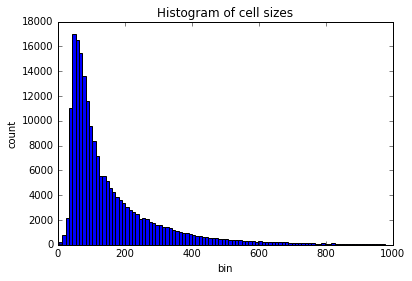

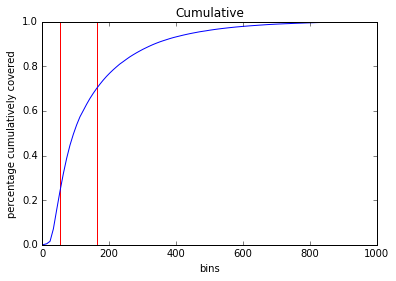

In [48]:
# plt.hist(cell_masks_normalized_size, bins=100);
# plt.title('Histogram of cell sizes');
# plt.xlabel('bin');
# plt.ylabel('count');
# plt.show();

# counts, edges = np.histogram(cell_masks_normalized_size, bins=100)
# counts = counts / float(n_cells)
# counts_cumsum = np.cumsum(counts)
# plt.plot(edges[:-1], counts_cumsum);
# plt.title('Cumulative');
# plt.xlabel('bins');
# plt.ylabel('percentage cumulatively covered');

# cutoff_percentage = .3 # 30% of the smallest cells will be below the threshold
# cell_size_threshold_small_medium = edges[np.where(counts_cumsum < cutoff_percentage)[0][-1]]
# plt.vlines(cell_size_threshold_small_medium, 0, 1, color='r');

# cutoff_percentage = .7
# cell_size_threshold_medium_large = edges[np.where(counts_cumsum < cutoff_percentage)[0][-1]]
# plt.vlines(cell_size_threshold_medium_large, 0, 1, color='r');
# plt.show();

In [81]:
cutoff_percentage_small_medium = .3
cutoff_percentage_medium_large = .7
c1 = int(cutoff_percentage_small_medium*n_cells)
c2 = int(cutoff_percentage_medium_large*n_cells)
indices_sorted_by_size = np.argsort(cell_masks_normalized_size)
small_cells_indices = indices_sorted_by_size[:c1]
medium_cells_indices = indices_sorted_by_size[c1:c2]
large_cells_indices = indices_sorted_by_size[c2:]

# small_cells_indices = np.where(cell_masks_normalized_size < cell_size_threshold_small_medium)[0]
# medium_cells_indices = np.where((cell_masks_normalized_size >= cell_size_threshold_small_medium) & \
#                                (cell_masks_normalized_size < cell_size_threshold_medium_large))[0]

# large_cells_indices = np.setdiff1d(range(n_cells), np.r_[small_cells_indices, medium_cells_indices])

print len(small_cells_indices), len(medium_cells_indices), len(large_cells_indices)

59385 79182 59386


In [84]:
nonsmall_cells_indices = np.sort(np.r_[medium_cells_indices, large_cells_indices])

In [96]:
nonsmall_cell_masks_normalized_flattened = cell_masks_normalized_flattened[nonsmall_cells_indices].copy()
nonsmall_cell_masks_normalized_size = cell_masks_normalized_size[nonsmall_cells_indices].copy()
print nonsmall_cell_masks_normalized_flattened.shape
n_nonsmallCells = len(nonsmall_cells_indices)

(138568, 9086)


In [94]:
from multiprocess import Pool
from scipy.spatial.distance import squareform

# def compute_jaccard_list_with_all(seed_indices):

#     pool = Pool(14)
#     affinities_to_seeds = pool.map(compute_jaccard_with_i, seed_indices)
#     pool.close()
#     pool.join()
#     return np.asarray(affinities_to_seeds)

# def compute_jaccard_with_i_list(i, indices):
#     intersections = cell_masks_normalized_flattened[indices[:,None], cell_masks_normalized_flattened[i]].sum(axis=1)
#     unions = cell_masks_normalized_size[i] + cell_masks_normalized_size[indices] - intersections
#     scores = intersections.astype(np.float)/unions
#     return scores
    
# def compute_jaccard_pairwise(indices, square_form=True, parallel=True):
#     n = len(indices)

#     if parallel:
#         pool = Pool(16)
#         pairwise_scores = pool.map(lambda x: compute_jaccard_with_i_list(x[0],x[1]), 
#                                    [(indices[i], indices[i+1:]) for i in range(n)])
#         pool.close()
#         pool.join()
#     else:
#         pairwise_scores = [compute_jaccard_with_i_list(indices[i], indices[i+1:]) for i in range(n)]
        
#     if square_form:
#         return squareform(np.concatenate(pairwise_scores))
#     else:
#         return pairwise_scores

# def compute_jaccard_with_i(i, upper=False):
#     if upper:
#         intersections_with_i = cell_masks_normalized_flattened[i+1:, cell_masks_normalized_flattened[i]].sum(axis=1)
#         unions_with_i = cell_masks_normalized_size[i] + cell_masks_normalized_size[i+1:] - intersections_with_i
#     else:
#         intersections_with_i = cell_masks_normalized_flattened[:, cell_masks_normalized_flattened[i]].sum(axis=1)
#         unions_with_i = cell_masks_normalized_size[i] + cell_masks_normalized_size - intersections_with_i
        
#     return intersections_with_i.astype(np.float)/unions_with_i


# def compute_jaccard_with_template(template):
#     intersections_with_template = [template[m].sum() for m in cell_masks_normalized_flattened]
#     unions_with_template = (template + cell_masks_normalized_size - intersections_with_template)
#     return intersections_with_template.astype(np.float)/unions_with_template

# def compute_jaccard_with_i_sparse(i, upper=False, threshold=.85, n_neighbors=10):
#     if upper:
#         scores = compute_jaccard_with_i(i, upper=True)
#         nearest_neighbors = np.where(scores > threshold)[0]
#         return i+1+nearest_neighbors, scores[nearest_neighbors]
#     else:
#         scores = compute_jaccard_with_i(i, upper=False)
#         nearest_neighbors = np.argsort(scores)[::-1][:10]
#         return nearest_neighbors, scores[nearest_neighbors]

In [113]:

def compute_jaccard_with_i_nonsmallCellsOnly(i):
    intersections_with_i = nonsmall_cell_masks_normalized_flattened[:, nonsmall_cell_masks_normalized_flattened[i]].sum(axis=1)
    unions_with_i = nonsmall_cell_masks_normalized_size[i] + nonsmall_cell_masks_normalized_size - intersections_with_i
        
    return intersections_with_i.astype(np.float)/unions_with_i

def compute_jaccard_pairwise_nonsmallCellsOnly(indices, square_form=True, parallel=True):
    n = len(indices)

    if parallel:
        pool = Pool(16)
        pairwise_scores = pool.map(lambda x: compute_jaccard_with_i_list_nonsmallCellsOnly(x[0],x[1]), 
                                   [(indices[i], indices[i+1:]) for i in range(n)])
        pool.close()
        pool.join()
    else:
        pairwise_scores = [compute_jaccard_with_i_list_nonsmallCellsOnly(indices[i], indices[i+1:]) for i in range(n)]
        
    if square_form:
        return squareform(np.concatenate(pairwise_scores))
    else:
        return pairwise_scores
    
    
def compute_jaccard_with_i_list_nonsmallCellsOnly(i, indices):
    intersections = nonsmall_cell_masks_normalized_flattened[indices[:,None], nonsmall_cell_masks_normalized_flattened[i]].sum(axis=1)
    unions = nonsmall_cell_masks_normalized_size[i] + nonsmall_cell_masks_normalized_size[indices] - intersections
    scores = intersections.astype(np.float)/unions
    return scores


def compute_jaccard_list_with_all_nonsmallCellsOnly(seed_indices):

    pool = Pool(14)
    affinities_to_seeds = pool.map(compute_jaccard_with_i_nonsmallCellsOnly, seed_indices)
    pool.close()
    pool.join()
    return np.asarray(affinities_to_seeds)

In [97]:
n_class = 1000

# distances_to_seeds = np.empty((n_class, n_cells))
# cluster_max_radius_evolution = np.empty((n_class, ))
# cluster_mean_radius_evolution = np.empty((n_class, ))
# cluster_random1_radius_evolution = np.empty((n_class, ))
# cluster_random100_radius_evolution = np.empty((n_class, ))
# cluster_random1run_radius_evolution = np.empty((n_class, ))
seeds = np.empty((n_class, ), np.int)

distances_to_closest_seed = np.empty((n_nonsmallCells, ))
indices_of_closest_seed = np.empty((n_nonsmallCells, ), np.int)

t1 = time.time()

bar = show_progress_bar(0, n_class)

for it in range(n_class):
            
    bar.value = it
        
    if it == 0:
        seed = np.random.randint(n_nonsmallCells)
    else:
        seed = np.random.choice(range(n_nonsmallCells), 1, p=d2_weights)[0]
        
    seeds[it] = int(seed)
    
#     t = time.time()
    distances = 1. - compute_jaccard_with_i_nonsmallCellsOnly(seed)
#     distances = 1. - compute_jaccard_with_i_parallel(seed)
#     print time.time() - t
    # sequential: 0.05-0.5s / 20k cells
    # parallel: 0.35s, even slower than sequential

    
    if it == 0:
        distances_to_closest_seed = distances
        indices_of_closest_seed[:] = 0
    else:    
        needs_update = distances < distances_to_closest_seed
        distances_to_closest_seed[needs_update] = distances[needs_update]
        indices_of_closest_seed[needs_update] = it
        
    d2s = distances_to_closest_seed**2
    d2_weights = d2s / d2s.sum()
    
#     # different ways to compute r
#     cluster_max_radius = np.max(distances_to_closest_seed)
#     cluster_mean_radius = np.mean(distances_to_closest_seed)
#     cluster_random1_radius = distances_to_closest_seed[np.random.randint(0, n_cells, 1)]
#     cluster_random100_radius = distances_to_closest_seed[np.random.randint(0, n_cells, 100)].mean()
    
#     if it == 0:
#         cluster_random1run_radius = cluster_random1_radius
#     else:
#         cluster_random1run_radius = (it * cluster_random1run_radius + cluster_random1_radius) / float(it+1)    
    
#     cluster_max_radius_evolution[it] = cluster_max_radius
#     cluster_mean_radius_evolution[it] = cluster_mean_radius
#     cluster_random1_radius_evolution[it] = cluster_random1_radius
#     cluster_random100_radius_evolution[it] = cluster_random100_radius
#     cluster_random1run_radius_evolution[it] = cluster_random1run_radius
    
#     print 2, time.time() - t
    
print time.time() - t1 # 21s / 100 iterations; 4800s / 20000 iters

# bp.pack_ndarray_file(seeds, '/home/yuncong/csd395/CSHL_cells/fractal_dim/seeds_%d.bp' % n_class)
# bp.pack_ndarray_file(distances_to_closest_seed, '/home/yuncong/csd395/CSHL_cells/fractal_dim/distancesToClosestSeed_%d.bp' % n_class)
# bp.pack_ndarray_file(indices_of_closest_seed, '/home/yuncong/csd395/CSHL_cells/fractal_dim/indicesToClosestSeed_%d.bp' % n_class)
# bp.pack_ndarray_file(cluster_mean_radius_evolution, '/home/yuncong/csd395/CSHL_cells/fractal_dim/clusterMeanRadiusEvolution_%d.bp' % n_class)
# bp.pack_ndarray_file(cluster_random1run_radius_evolution, '/home/yuncong/csd395/CSHL_cells/fractal_dim/clusterRand1RunRadiusEvolution_%d.bp' % n_class)

159.724170923


In [99]:
memberCount = np.bincount(indices_of_closest_seed, minlength=len(seeds))
seedIndices_sorted_by_memberCount = np.argsort(memberCount)[::-1]
memberCount_sorted = memberCount[seedIndices_sorted_by_memberCount]
seeds_ranked_by_memberCount = seeds[seedIndices_sorted_by_memberCount]

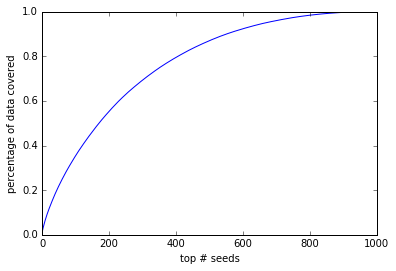

In [104]:
plt.plot(np.cumsum(memberCount_sorted) / float(n_nonsmallCells));
plt.xlabel('top # seeds');
plt.ylabel('percentage of data covered');

In [123]:
# our data, Nystroem extension
# https://people.eecs.berkeley.edu/~malik/papers/FBCM-nystrom.pdf

t = time.time()

n_seeds = 200
sampled = seeds_ranked_by_memberCount[:n_seeds].copy()

affinities_with_samples = compute_jaccard_list_with_all_nonsmallCellsOnly(sampled)

sys.stderr.write('Compute pairwise affinities (with samples): %f s.\n' % (time.time()-t))

Compute pairwise affinities (with samples): 9.674370 s.


In [124]:
nonsampled = np.setdiff1d(range(affinities_with_samples.shape[1]), sampled)
permutation = np.r_[sampled, nonsampled]

In [125]:
t = time.time()

from scipy.linalg import sqrtm

A = affinities_with_samples[:, sampled].copy()
B = affinities_with_samples[:, nonsampled].copy()

d1 = np.sum(np.c_[A, B], axis=1)
Ai = np.linalg.inv(A)
d2 = np.sum(B, axis=0) + np.dot(B.T, np.dot(Ai, np.sum(B, axis=1)))
dhat_si = np.sqrt(1./np.r_[d1, d2])
A = A*np.outer(dhat_si[:n_seeds], dhat_si[:n_seeds])
B = B*np.outer(dhat_si[:n_seeds], dhat_si[n_seeds:])

Asi = sqrtm(Ai)

M = np.dot(B.T, Asi)
S = A + np.dot(M.T, M)

U, L, T = np.linalg.svd(S)

V = np.dot(np.vstack([A, B.T]), np.dot(Asi, np.dot(U, np.linalg.inv(np.diag(np.sqrt(L))))))

sys.stderr.write('Nystroem: %f s.\n' % (time.time()-t)) # 60s / 100 samples

Nystroem: 94.123109 s.


In [126]:
E_allEig = V[:,1:]/V[:,0][:,None]

In [127]:
E_allEig_original_order = np.zeros_like(E_allEig)
E_allEig_original_order[permutation] = E_allEig

bp.pack_ndarray_file(E_allEig_original_order, 
                     '/home/yuncong/csd395/CSHL_cells/fractal_dim/embeddingAllEigen_nonsmallCells_nystromSample%d.bp' % n_seeds)

# print E_allEig_original_order.mean(axis=0)
# print E_allEig_original_order.std(axis=0)

E_allEig_original_order_normalized = (E_allEig_original_order-E_allEig_original_order.mean(axis=0))/E_allEig_original_order.std(axis=0)

bp.pack_ndarray_file(E_allEig_original_order_normalized, 
                     '/home/yuncong/csd395/CSHL_cells/fractal_dim/embeddingAllEigenNormalized_nonsmallCells_nystromSample%d.bp' % n_seeds)

In [128]:
bp.pack_ndarray_file(nonsmall_cells_indices, '/home/yuncong/csd395/CSHL_cells/fractal_dim/nonsmallCells_indices_cutoff%d.bp' % (cutoff_percentage_small_medium*100))